# ***Lesson 1 OLS and WLS***

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

plt.rcParams["figure.figsize"] = (14, 8)  # Figure size and width

In [2]:
df = pd.read_csv('M2. module_2_data.csv')

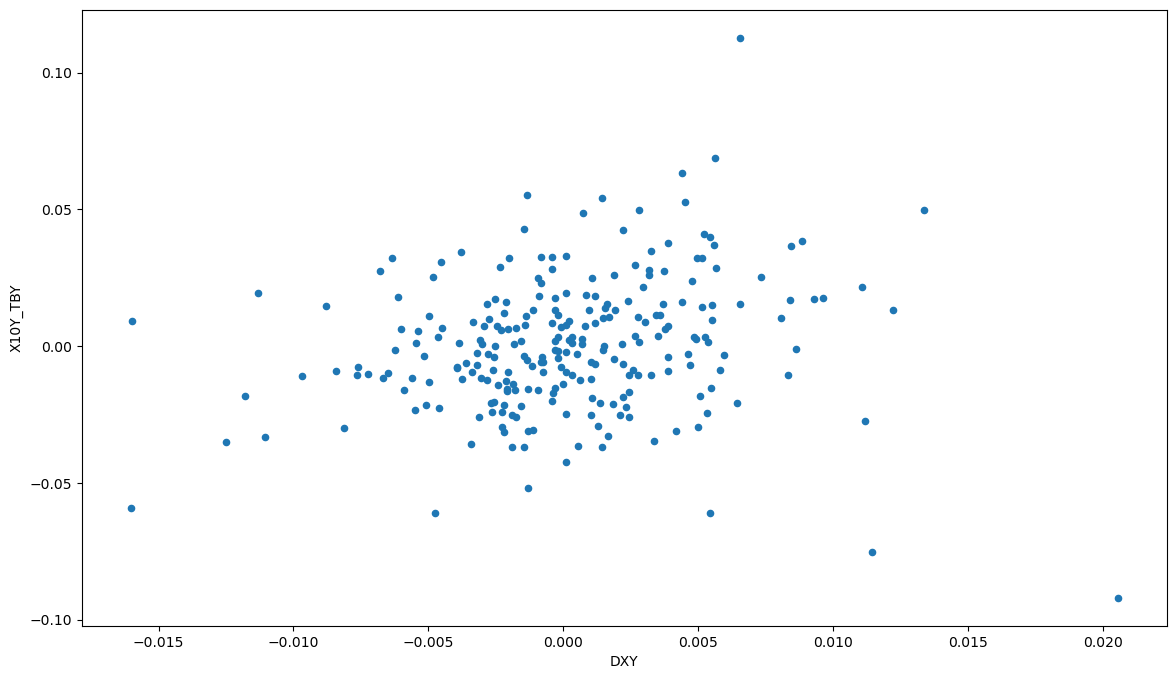

In [13]:
scatt = df.plot.scatter(x='DXY', y='X10Y_TBY')
scatt.set(xlabel='DXY', ylabel='X10Y_TBY')
plt.show();

In [14]:
model1 = smf.ols('DXY ~ X10Y_TBY', data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DXY   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.738
Date:                Sun, 18 May 2025   Prob (F-statistic):            0.00582
Time:                        20:55:57   Log-Likelihood:                 986.78
No. Observations:                 250   AIC:                            -1970.
Df Residuals:                     248   BIC:                            -1963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.474      0.636      -0.000       0.001
X10Y_TBY       0.0336      0.012      2.782      0.006       0.010       0.057
==============================================================================
Omnibus:                       26.741   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.918
Skew:                           0.322   Prob(JB):                     2.45e-21
Kurtosis:                       5.949   Cond. No.                         40.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

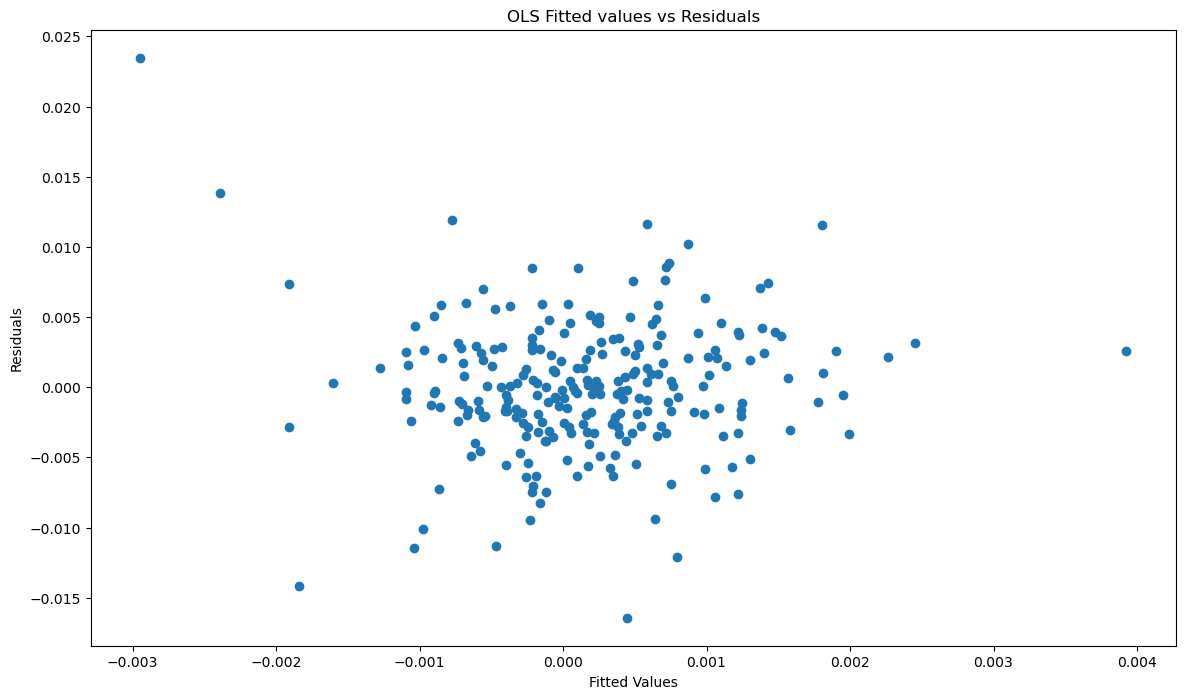

In [15]:
model_fitted_y = model1.fittedvalues
model_residuals = model1.resid

plt.scatter(x = model_fitted_y, y = model_residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('OLS Fitted values vs Residuals');

In [16]:
name = ['Lagrange Multiplier Statistic', 'LM p-value', 'F-value', 'F p-value']
test = sms.het_breuschpagan(model1.resid, model1.model.exog)
pd.DataFrame(test, index=name, columns=[''])

,
Lagrange Multiplier Statistic,13.897238
LM p-value,0.000193
F-value,14.597521
F p-value,0.000168


In [21]:
#Running WLS
#Adding absolute residuals : 
df['absolute_residuals'] = np.abs(model1.resid)
df['fitted_values'] = model1.fittedvalues

#Run OLS with fitted and absolute resid
model_temp = smf.ols('absolute_residuals ~ fitted_values', data=df).fit()

#Compute weights and add to df
weights = model_temp.fittedvalues
weights = weights**-2
df['weights'] = weights

#Fit WLS : 
Y = df['DXY'].tolist()
X = df['X10Y_TBY'].tolist()
X = sm.add_constant(X)

model_WLS = sm.WLS(Y, X, df['weights']).fit()
model_WLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.100
Model:                            WLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     27.59
Date:                Sun, 18 May 2025   Prob (F-statistic):           3.23e-07
Time:                        21:09:39   Log-Likelihood:                 994.52
No. Observations:                 250   AIC:                            -1985.
Df Residuals:                     248   BIC:                            -1978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.346      0.730      -0.000       0.001
x1             0.0516      0.010      5.253      0.000       0.032       0.071
==============================================================================
Omnibus:                       10.978   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               23.475
Skew:                           0.063   Prob(JB):                     7.99e-06
Kurtosis:                       4.496   Cond. No.                         35.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Residuals')

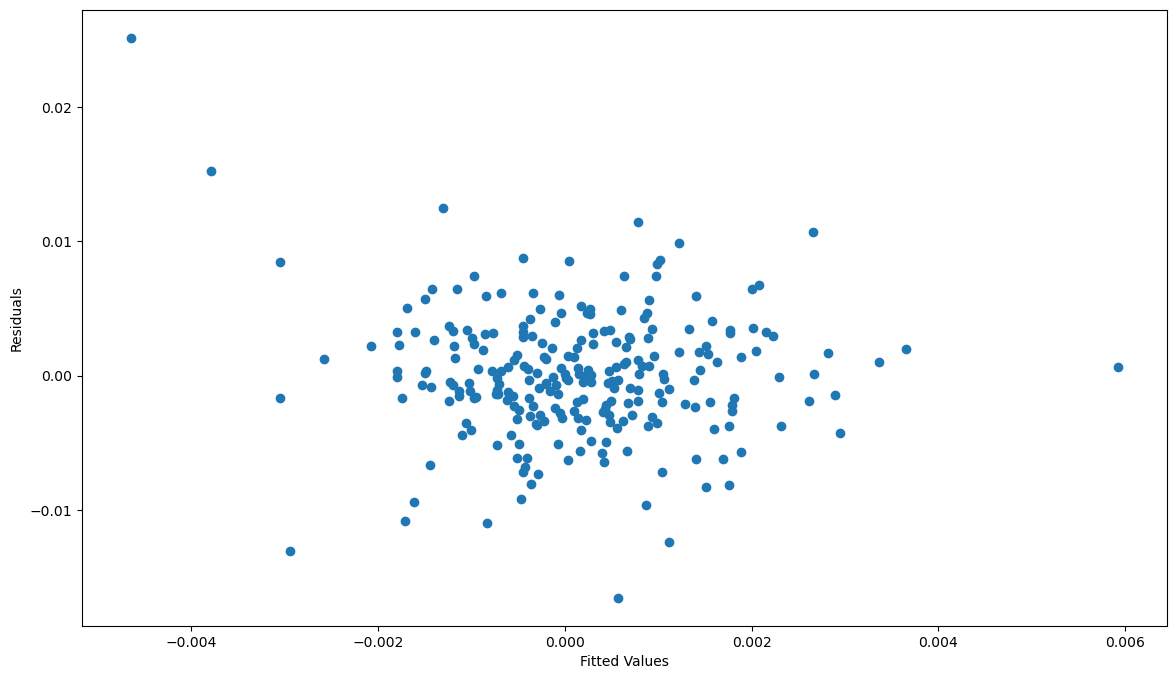

In [22]:
fitted_values_WLS = model_WLS.fittedvalues
residuals_WLS = model_WLS.resid

plt.scatter(x = fitted_values_WLS, y=residuals_WLS)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

In [31]:
hettest = sms.het_breuschpagan(residuals_WLS, model_WLS.model.exog)
pd.DataFrame(hettest, index=name, columns=[''])

,
Lagrange Multiplier Statistic,16.494670
LM p-value,0.000049
F-value,17.518565
F p-value,0.000040


## Synthetic Data WLS procedure
### 1. Var = ε^2*x^2

In [ ]:
#DGP
np.random.seed(0)
n=10000
x = np.random.normal(5,1.5,n)
eps = np.random.normal(0,1,n)
y = 0.5+2*x + eps*x
#E(y | x) = 0.5+2*x, V(y|x) = eps^2*x^2
#Prepare data
df_synth = pd.DataFrame({
    'y' : y,
    'x' : x, 
    'e' : eps
})
X = sm.add_constant(df_synth['x'])
y = df_synth['y']

#Esimate OLS and get residuals: 
model_OLS = sm.OLS(y,X).fit()
resid = model_OLS.resid


#Conduct test on distribution of residuals
resid_OLS = model_OLS.resid
test_het = sms.het_breuschpagan(resid_OLS, model_OLS.model.exog)
BP_results_OLS = pd.DataFrame(test_het, index=name, columns=[''])
print(BP_results_OLS)

#Estimate Variance : 
var_mod = sm.OLS(resid**2, sm.add_constant(df_synth['x']**2)).fit()
pred_var = var_mod.fittedvalues

#Weights = 1/pred var : 
weights = 1/pred_var

#Fit WLS 
WLS_est = sm.WLS(y,X, weights = weights).fit()

#Scale the residuals (to test for heteroskedasticity in WLS) : otherwise, BP considers we are still in original WLS
resid_scaled = WLS_est.resid*np.sqrt(weights) #weights in this model should theoretically be 1/x^2. Since our model error is e*x, by taking sqrt(weight)
#we therefore put the residuals at e*x*1/sqrt(x2) = e

#Test heteroskedasticity : 
WLS_BP_test = sms.het_breuschpagan(resid_scaled, WLS_est.model.exog)
BP_results_WLS = pd.DataFrame(WLS_BP_test, index=name, columns=[''])
print(BP_results_WLS)
print(model_OLS.summary())
print(WLS_est.summary())

                                            
Lagrange Multiplier Statistic   9.969466e+02
LM p-value                     8.278835e-219
F-value                         1.107121e+03
F p-value                      2.494535e-230
                                       
Lagrange Multiplier Statistic  0.194519
LM p-value                     0.659181
F-value                        0.194484
F p-value                      0.659220
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     3238.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        14:34:59   Log-Likelihood:                -30585.
No. Observations:               10000   AIC:                         6.117e+04
Df Residuals:         

Lagrange Multiplier Statistic   1.014766e+03
LM p-value                     1.108324e-222
F-value                         1.129145e+03
F p-value                      1.235397e-234
                                       
Lagrange Multiplier Statistic  1.854052
LM p-value                     0.173313
F-value                        1.854025
F p-value                      0.173347

### 2. Var = sig^2*x^4


                                          
Lagrange Multiplier Statistic  1629.108476
LM p-value                        0.000000
F-value                        1945.769634
F p-value                         0.000000
                                       
Lagrange Multiplier Statistic  1.392094
LM p-value                     0.238052
F-value                        1.392009
F p-value                      0.238094
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.882
Date:                Mon, 19 May 2025   Prob (F-statistic):             0.0153
Time:                        14:27:51   Log-Likelihood:                -54804.
No. Observations:               10000   AIC:                         1.096e+05
Df Residuals:                   

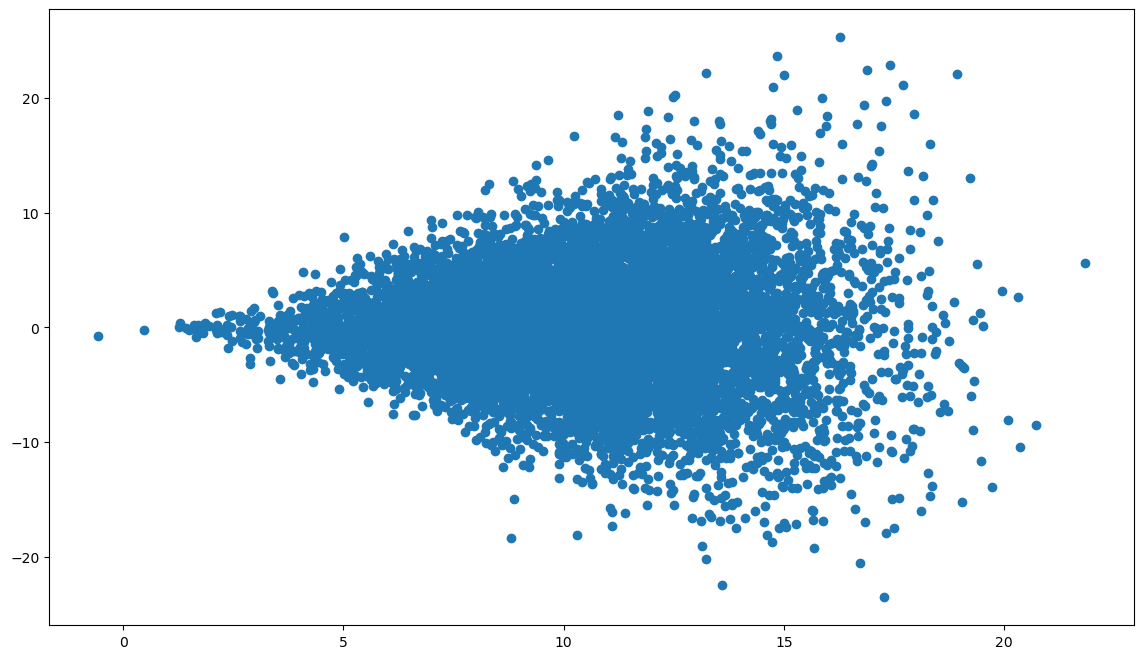

In [121]:
plt.scatter(model_OLS.fittedvalues, resid_OLS)

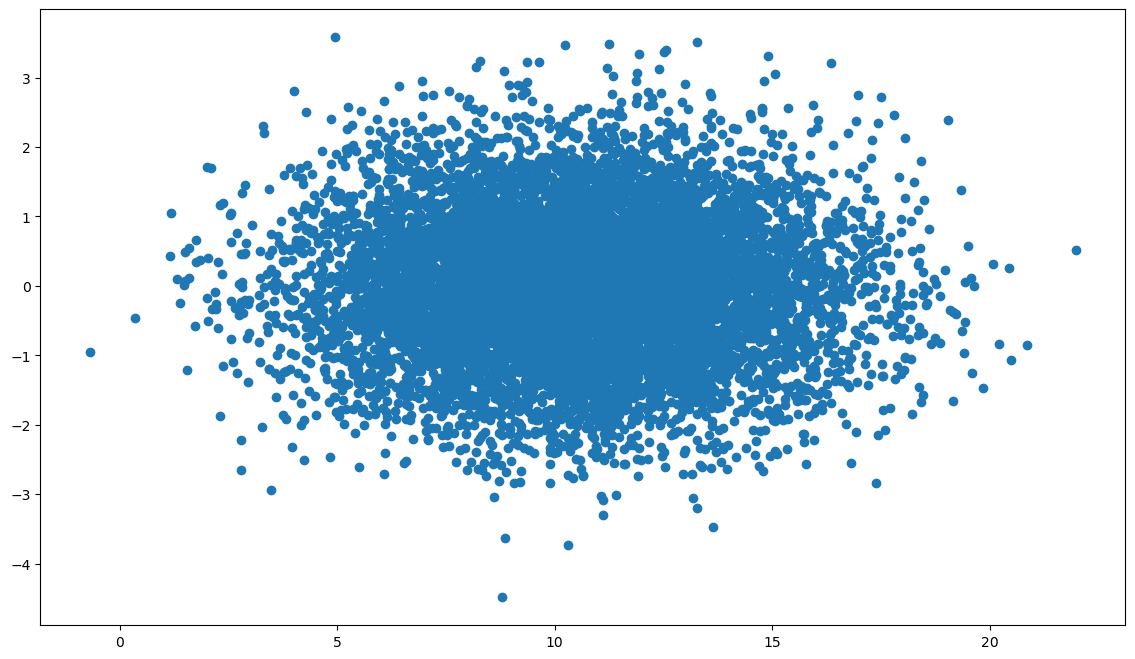

In [122]:
plt.scatter(WLS_est.fittedvalues, resid_scaled)

# ***Lecture 2***

In [130]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

In [123]:
df = pd.read_csv('M2. module_2_data.csv')

## **Robust Regression**
### *Huber Model*

In [ ]:
rr_huber = sm.RLM(
    df['DXY'], sm.add_constant(df['X10Y_TBY']), M = sm.robust.norms.HuberT()
)
rr_huber_results = rr_huber.fit()
rr_huber_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    DXY   No. Observations:                  250
Model:                            RLM   Df Residuals:                      248
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 May 2025                                         
Time:                        18:53:42                                         
No. Iterations:                    19                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.673e-05      0.000      0.367      0.714      -0.000       0.001
X10Y_TBY       0.0446      0.011      4.152      0.000       0.024       0.066
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### *Bisquare Model*

In [125]:
rr_bisquare = sm.RLM(
    df['DXY'], sm.add_constant(df['X10Y_TBY']), M = sm.robust.norms.TukeyBiweight()
)
rr_bisquare_results = rr_bisquare.fit()
rr_bisquare_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    DXY   No. Observations:                  250
Model:                            RLM   Df Residuals:                      248
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 May 2025                                         
Time:                        19:01:49                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.698e-05      0.000      0.254      0.800      -0.000       0.001
X10Y_TBY       0.0515      0.011      4.797      0.000       0.030       0.073
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### *WLS*

In [128]:
model_1 = sm.OLS(df['DXY'], sm.add_constant(df['X10Y_TBY'])).fit()

#Add absolute residuals 
df['abs_res'] = np.abs(model_1.resid)
df['fitted_values'] = model_1.fittedvalues

#Fit OLS with abs res and FV
model_temp = sm.OLS(df['abs_res'], sm.add_constant(df['fitted_values'])).fit()

#Compute weights adn add to df
weights = model_temp.fittedvalues**-2
df['weights'] = weights

#WLS
y = df['DXY'].to_list()
X = sm.add_constant(df['X10Y_TBY'].to_list())

model_WLS = sm.WLS(y,X, weights = df['weights']).fit()
model_WLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.100
Model:                            WLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     27.59
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.23e-07
Time:                        19:14:41   Log-Likelihood:                 994.52
No. Observations:                 250   AIC:                            -1985.
Df Residuals:                     248   BIC:                            -1978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.346      0.730      -0.000       0.001
x1             0.0516      0.010      5.253      0.000       0.032       0.071
==============================================================================
Omnibus:                       10.978   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               23.475
Skew:                           0.063   Prob(JB):                     7.99e-06
Kurtosis:                       4.496   Cond. No.                         35.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

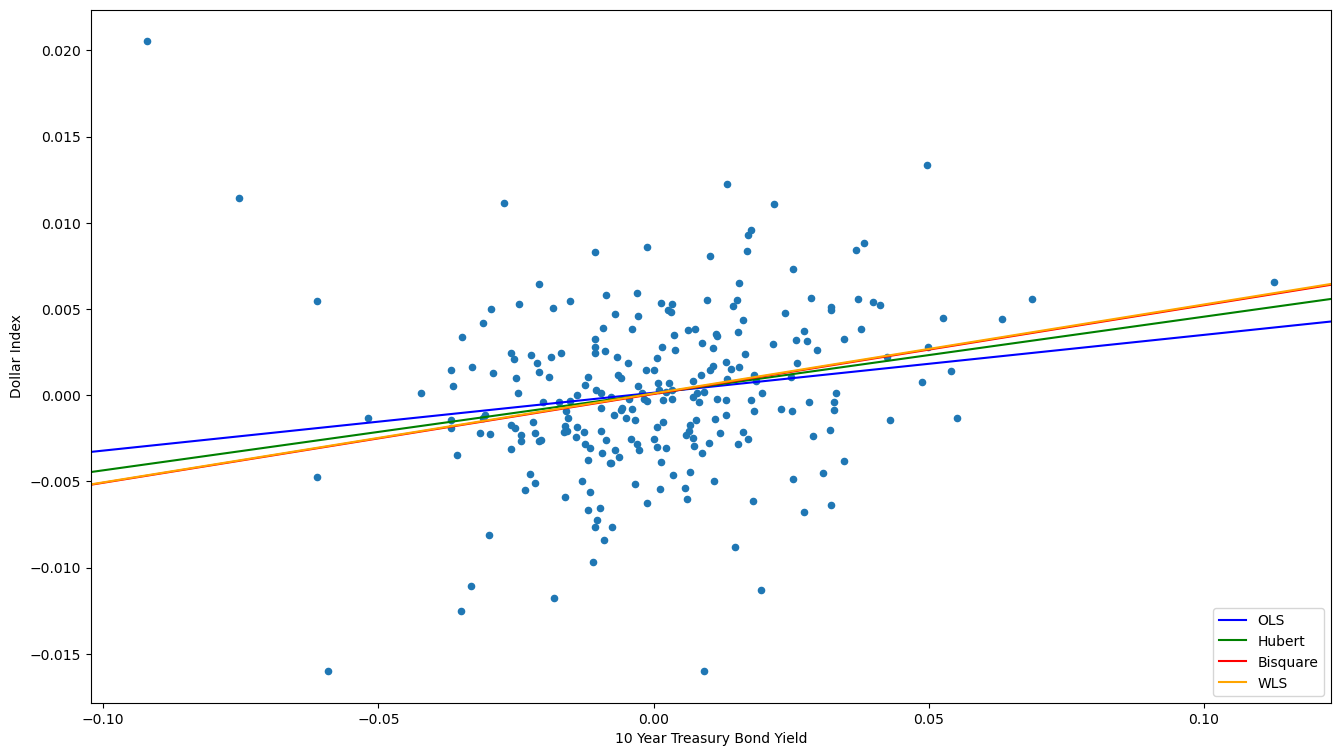

In [132]:
#Scatter plot 
scatt = df.plot(x='X10Y_TBY', y='DXY', kind='scatter')
scatt.set(xlabel='10 Year Treasury Bond Yield', ylabel = 'Dollar Index')

#Regression lines
abline_plot(model_results=model_1, ax=scatt, color='blue', label='OLS')
abline_plot(model_results=rr_huber_results, ax=scatt, color='green', label='Hubert')
abline_plot(model_results=rr_bisquare_results, ax=scatt, color='red', label='Bisquare')
abline_plot(model_results=model_WLS, ax=scatt, color='orange', label='WLS')
plt.legend(loc='lower right')
plt.show()

# ***LESSON 3 Penalized Regression***

In [174]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split

In [192]:
np.random.seed(11111)
nrow = df.shape[0]
train_sequence = sorted(np.random.choice(nrow, int(nrow*0.8), replace=False))
test_sequence = sorted(set(list(range(0, nrow))) - set(train_sequence))

train = df.filter(items=train_sequence, axis=0)
test = df.filter(items=test_sequence, axis=0)

ind_var = ["METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"]

train_x = train.loc[:, ind_var]
train_y = train.DXY

test_x = test.loc[:,ind_var]
test_y = test.DXY

test_tot = test.loc[:, ["DXY", "METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"]]

In [197]:
#OLS
ols_final = sm.OLS(train_y, sm.add_constant(train_x)).fit()
print(ols_final.summary2().tables[1])

#Compute test R2 and MSE : 
ols_pred = ols_final.predict(sm.add_constant(test_x))
ols_pred = pd.DataFrame(ols_pred, columns=['ols_p'])
ols_actual = test.DXY

ols_rss = np.sum(np.power(ols_actual-ols_pred.ols_p,2))
ols_tss = np.sum(np.power(ols_actual - np.mean(ols_actual), 2))
ols_rsq = 1 - ols_rss/ols_tss
print('\n OLS R^2 : ', ols_rsq)

ols_mse = np.sqrt(ols_rss/test.shape[0])
print('\n OLS MSE : ', ols_mse)


             Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
const     0.000410  0.000310  1.321022  1.880502e-01 -0.000202  0.001022
METALS   -0.070259  0.010999 -6.387663  1.219474e-09 -0.091952 -0.048566
US_STK   -0.058324  0.040419 -1.442997  1.506340e-01 -0.138040  0.021392
X10Y_TBY  0.019521  0.013955  1.398854  1.634535e-01 -0.008002  0.047045
X13W_TB   0.000696  0.003924  0.177426  8.593591e-01 -0.007044  0.008436
EURUSD   -0.087070  0.059863 -1.454492  1.474259e-01 -0.205135  0.030995

 OLS R^2 :  0.10633201319436236

 OLS MSE :  0.00381807095301603


## Ridge Regression

In [198]:
lambdas = [np.power(10,i) for i in np.arange(4, -4, -0.1)]
alphas = lambdas

#Scale : 
#train_x_scale = scale(train_x)

#10-fold CV : 
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(train_x, train_y )

#Build final 
ridge_final = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True)
ridge_final.fit(train_x, train_y)

print(
    "\n",
    pd.DataFrame(
        (ridge_final.coef_),
        index=["METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"],
        columns=["Coef."],
    ),
)

ridge_pred = ridge_final.predict(test_x)
ridge_actual = test.DXY
ridge_rss = np.sum(np.power(ridge_pred - ridge_actual, 2))
ridge_tss = np.sum(np.power(ridge_actual - np.mean(ridge_actual), 2))
ridge_rsq = 1 - ridge_rss / ridge_tss
print("\n Ridge_R^2", ridge_rsq)

ridge_MSE = np.sqrt(ridge_rss / test.shape[0])
print("Ridge_SME", ridge_MSE)


              Coef.
METALS   -0.061364
US_STK   -0.016407
X10Y_TBY  0.015374
X13W_TB   0.001258
EURUSD   -0.012517

 Ridge_R^2 0.12384290357405436
Ridge_SME 0.003780479486607715


# Lasso Regression

In [199]:
lambdas = [np.power(10, i) for i in np.arange(6, -6, -0.1)]

lasso_cv = LassoCV(cv=10, alphas=lambdas)
lasso_cv.fit(train_x, train_y)

lasso_final = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True)
lasso_final.fit(train_x, train_y)

print(
    "\n",
    pd.DataFrame(
        (lasso_final.coef_),
        index=["METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"],
        columns=["Coef."],
    ),
)

lasso_pred = lasso_final.predict(test_x)
lasso_actual = test.DXY
lasso_rss = np.sum(np.power(lasso_pred - lasso_actual, 2))
lasso_tss = np.sum(np.power(lasso_actual - np.mean(lasso_actual), 2))
lasso_rsq = 1 - lasso_rss / lasso_tss
print("\n LASSO_R^2: ", lasso_rsq)

lasso_MSE = np.sqrt(lasso_rss / test.shape[0])
print("LASSO_SME: ", lasso_MSE)


              Coef.
METALS   -0.059688
US_STK   -0.000000
X10Y_TBY  0.000000
X13W_TB   0.000000
EURUSD   -0.000000

 LASSO_R^2:  0.14151036558996766
LASSO_SME:  0.00374216922006709


In [203]:
OLS_df = pd.DataFrame(
    ols_final.summary2().tables[1]['Coef.']).rename(
        columns = {'Coef.':'OLS'}
    )


Ridge_df = pd.DataFrame(
    np.insert(ridge_final.coef_, 0, ridge_final.intercept_),
    index = ["Intercept", "METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"],
    columns= ['Ridge']
)

Lasso_df = pd.DataFrame(
    np.insert(lasso_final.coef_, 0, lasso_final.intercept_),
    index = ["Intercept", "METALS", "US_STK", "X10Y_TBY", "X13W_TB", "EURUSD"],
    columns= ['Lasso']
)

df= OLS_df.merge(Ridge_df, left_index=True, right_index=True)
df = df.merge(Lasso_df, left_index=True, right_index=True)

df = pd.concat(
    [
        df,
        pd.DataFrame(
            {
                'OLS' : [ols_rsq, ols_mse],
                'Ridge' : [ridge_rsq, ridge_MSE],
                'Lasso': [lasso_rsq, lasso_MSE]
            },
            index=["R sq", "Mean Sq. Err"]
        )
    ]
)
display(df)

,OLS,Ridge,Lasso
METALS,-0.070259,-0.061364,-0.059688
US_STK,-0.058324,-0.016407,-0.000000
X10Y_TBY,0.019521,0.015374,0.000000
X13W_TB,0.000696,0.001258,0.000000
EURUSD,-0.087070,-0.012517,-0.000000
R sq,0.106332,0.123843,0.141510
Mean Sq. Err,0.003818,0.003780,0.003742


In [207]:
lowess_sm = sm.nonparametric.lowess
from supersmoother import SuperSmoother
plt.rcParams["figure.figsize"] = (16, 9)

In [208]:
df = pd.read_csv('M2. module_2_data.csv')

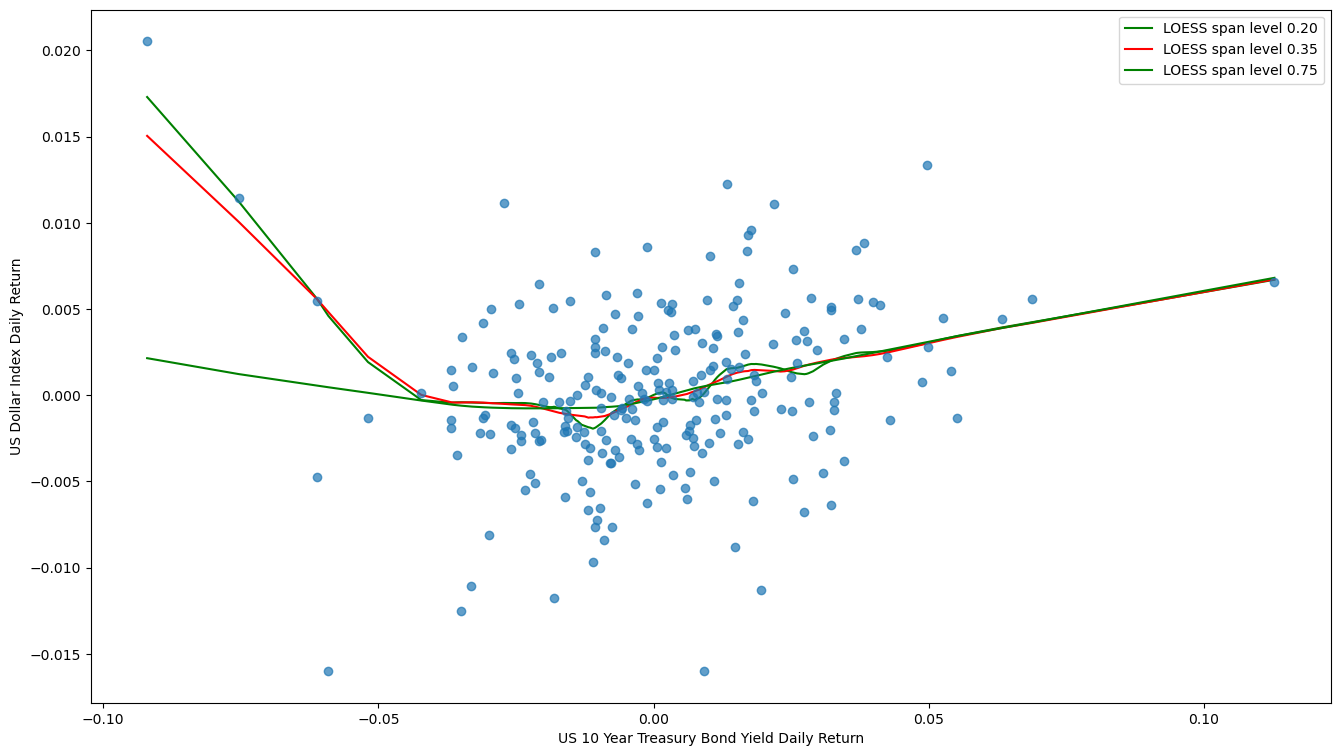

In [215]:
smoothed20 = lowess_sm(df.DXY, df.X10Y_TBY, frac=0.2, it=4)
smoothed35 = lowess_sm(df.DXY, df.X10Y_TBY, frac=0.35, it=4)
smoothed75 = lowess_sm(df.DXY, df.X10Y_TBY, frac=0.75, it=4)
plt.errorbar(df.X10Y_TBY, df.DXY, fmt="o", alpha=0.7);
plt.plot(smoothed20[:, 0], smoothed20[:, 1], c="g", label="LOESS span level 0.20")
plt.plot(smoothed35[:, 0], smoothed35[:, 1], c="r", label="LOESS span level 0.35")
plt.plot(smoothed75[:, 0], smoothed75[:, 1], c="g", label="LOESS span level 0.75")
plt.xlabel("US 10 Year Treasury Bond Yield Daily Return")
plt.ylabel("US Dollar Index Daily Return")
plt.legend();

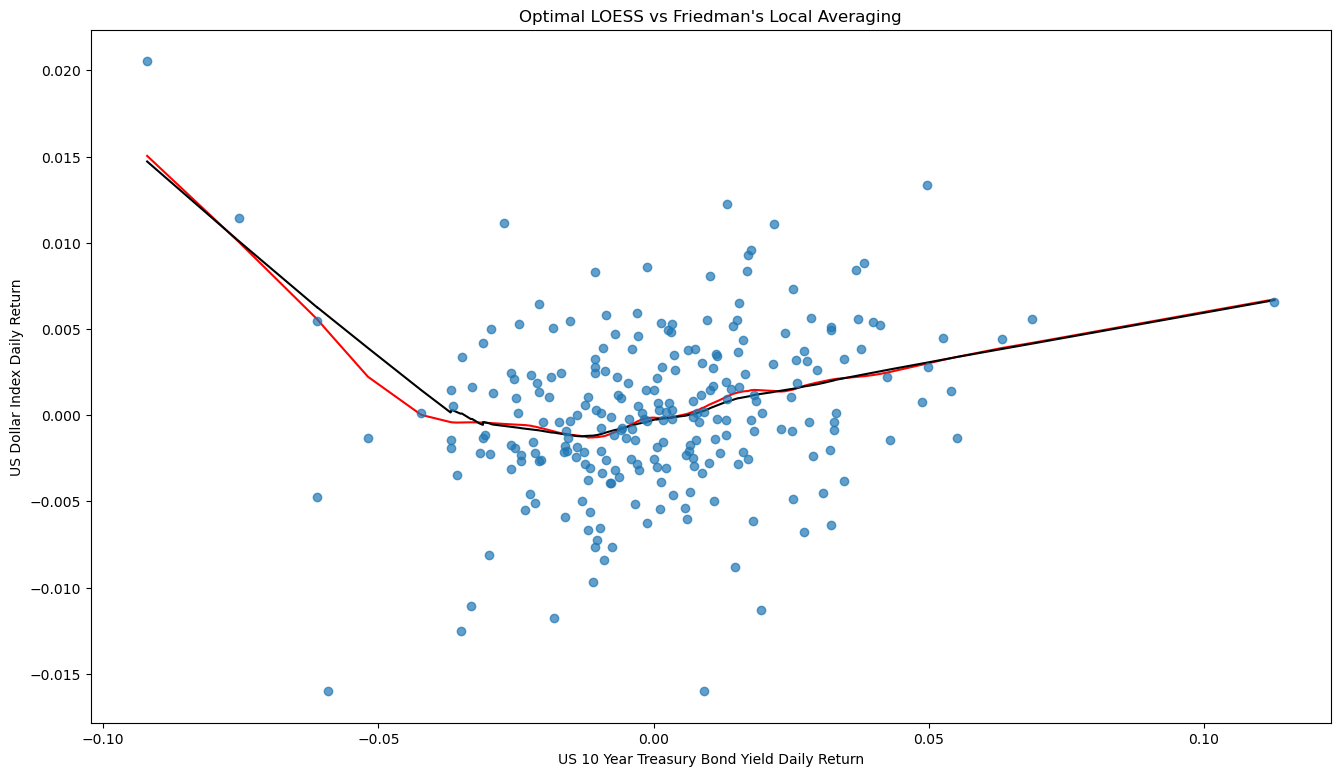

In [222]:
model = SuperSmoother(alpha = None, period = None, final_span=0.138)
model.fit(
    df.X10Y_TBY, 
    df.DXY, 
    np.ones(len(df.DXY))
)
fit_DXY = model.predict(df.X10Y_TBY)

temp_data = pd.DataFrame([df.X10Y_TBY, fit_DXY]).T
temp_data.columns = ['fit_DXY', 'X10Y_TBY']
temp_data = temp_data.sort_values(by='fit_DXY')

plt.errorbar(df.X10Y_TBY, df.DXY, fmt="o", alpha=0.7)
plt.plot(smoothed35[:, 0], smoothed35[:, 1], c="r", label="Optimal LOESS")
plt.plot(temp_data.fit_DXY, temp_data.X10Y_TBY, "-k", label="Friedman's SuperSmoother")

plt.title("Optimal LOESS vs Friedman's Local Averaging")
plt.xlabel("US 10 Year Treasury Bond Yield Daily Return")
plt.ylabel("US Dollar Index Daily Return");